In [ ]:
# library imports
import numpy as np
import pandas as pd
import pmdarima as pm

# just for jupyter notebooks plot size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Data set up

In [2]:
# data read
data = pd.read_csv("../data/data_tf.csv", parse_dates=["date"])
metadata = pd.read_csv("../data/meta_data.csv")

# target variable = GDP
target_variable = "gdpc1"
target_lag = 1 # GDP published after completion of the next month

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(-2, 3))

# train and test dates
train_start_date = "1947-01-01"
test_start_date = "2005-03-01"
test_end_date = "2010-03-01"

# train and test datasets
test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [3]:
data.tail()

,date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,...,ir,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea
908,2022-09-01,0.001761,0.008012,0.003860,0.002038,-0.134675,-0.001673,-0.054054,-0.028515,0.003825,...,-0.010373,0.005759,0.004644,0.003443,0.014267,0.002561,0.002485,0.005911,-0.009476,0.002056
909,2022-10-01,0.001856,NaN,0.004384,0.007362,0.082290,0.013066,0.057143,-0.021160,-0.000625,...,-0.004193,0.002715,0.002616,0.003729,-0.033248,-0.001789,0.002913,NaN,-0.003827,NaN
910,2022-11-01,0.001716,NaN,0.000963,-0.020892,0.057851,-0.005824,0.000000,-0.004881,-0.002195,...,-0.006316,0.001987,0.001681,0.001043,-0.106481,-0.003271,NaN,NaN,-0.002561,NaN
911,2022-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
912,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Training the model

In [4]:
# training ARMA model for order
train_series = test.loc[(~pd.isna(test[target_variable])) & (test.date < test_start_date), target_variable].reset_index(drop=True) # only the target series is used in the ARMA model
model = pm.auto_arima(train_series, seasonal=False, stationary=True)
ar_order = model.order[0]
ma_order = model.order[2]

# Testing the model on artificial data vintages

In [5]:
# dates in the test set
dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)

In [ ]:
pred_dict = {k: [] for k in lags}
for lag in lags:
    for date in dates:
        test_series = test.loc[test.date <= date, ["date", target_variable]]
        test_series.iloc[len(test_series)+lag-1-target_lag:,1] = np.nan # simulated vintage
        
        # make sure target variable isn't given
        test_series.loc[test_series.date == date,target_variable] = np.nan
        
        ts = test_series.loc[~pd.isna(test_series[target_variable])].reset_index(drop=True)
        ts_dates = ts.date
        ts_series = ts[target_variable]

        ts_model = pm.arima.ARIMA((ar_order, 0, ma_order))
        preds = ts_model.fit_predict(ts_series)

        # make sure getting right date for prediction
        final_dates = pd.date_range(ts_dates[0], periods=len(ts_dates)+10, freq="3MS")
        final_preds = list(ts_series) + list(preds)
        final = pd.DataFrame({"date":final_dates, "preds":final_preds})
        pred = final.loc[final.date == date, "preds"].values[0]
        
        pred_dict[lag].append(pred)

# Assess and visualize model performance

In [7]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2))
    }, index=[0])
    performance = pd.concat([performance, tmp]).reset_index(drop=True)
performance.round(4)

,Vintage,RMSE
0,-2,0.0091
1,-1,0.0079
2,0,0.0079
3,1,0.0079
4,2,0.0079


''

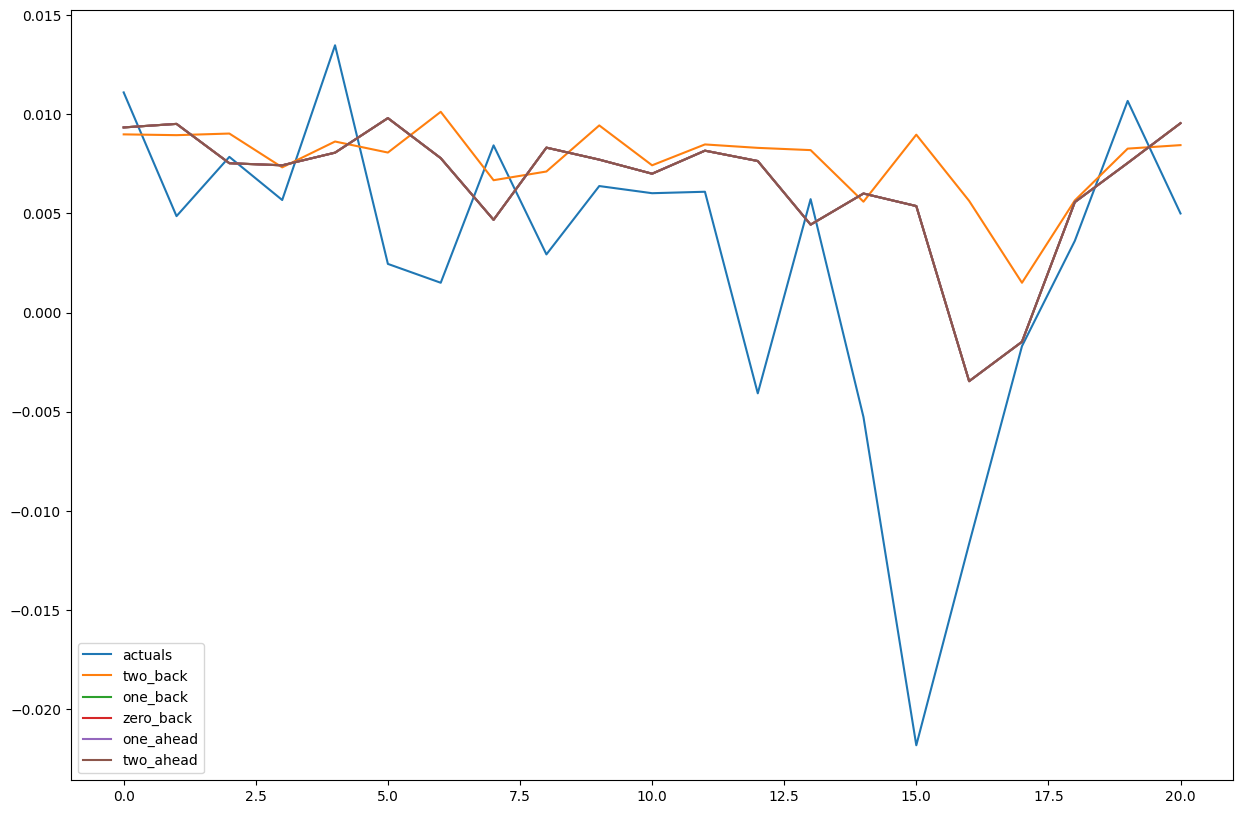

In [8]:
# plot of predictions vs actuals
pd.DataFrame({
    "actuals":actuals, 
    "two_back":pred_dict[-2], 
    "one_back":pred_dict[-1], 
    "zero_back":pred_dict[0],
    "one_ahead":pred_dict[1],
    "two_ahead":pred_dict[2]}
).plot()
;

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [9]:
# the test data ends 2010-03-01, let's say we wanted to predict 2010-06-01
new_data = test.copy()
ts_series = new_data.loc[~pd.isna(new_data[target_variable]), target_variable]
ts_model = pm.arima.ARIMA((ar_order, 0, ma_order))
preds = ts_model.fit_predict(ts_series, n_periods=10) # n_periods is how many periods ahead to generate predictions

In [10]:
# obtain prediction for the new period
preds[0] # first prediction is the next period, so 2010-06-01

0.007997893224618805